In [26]:
from bs4 import BeautifulSoup
import requests
import nltk
import os
from nltk import sent_tokenize, word_tokenize
import re
import urllib
from collections import Counter
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns




In [2]:
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(nltk.corpus.stopwords.words())


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/husain3012/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/husain3012/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Data Acquisition and Preprocessing

In [8]:
def fetch_webpage(url):
    response = requests.get(url)
    return response.text


def clean_text(text):
    text_cleanup_regex = r'[^A-Za-z ]+'

    cleaned_text = re.sub(text_cleanup_regex,' ', text)

    # remove multiple spaces
    cleaned_text = re.sub(' +', ' ', cleaned_text)

    cleaned_text.strip()
    cleaned_text = cleaned_text.lower()


    # remove stop words
    words = word_tokenize(cleaned_text)
    cleaned_text = ' '.join([word for word in words if word not in stop_words])
    return cleaned_text

def parse_webpage(text):
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    cleaned_text = clean_text(text)
    return cleaned_text



def fetch_wikipedia_pages(category, n, save_to=None):
    processed = 0
    S = requests.Session()

    URL = "https://en.wikipedia.org/w/api.php"

    PARAMS = {
        "action": "query",
        "cmtitle": "Category:" + category,
        "cmlimit": n,
        "list": "categorymembers",
        "format": "json"
    }

    R = S.get(url=URL, params=PARAMS)
    DATA = R.json()
    PAGES = DATA['query']['categorymembers']

    page_ids = [page['pageid'] for page in PAGES]

    pages = []
    #get the content of each page by pageid and save it to a file
    for page_id in page_ids:
        PARAMS = {
            "action": "parse",
            "pageid": page_id,
            "format": "json"
        }
        R = S.get(url=URL, params=PARAMS)
        #use beautifulsoap to parse the content
        DATA = R.json()
        content = DATA['parse']['text']['*']
        text = parse_webpage(content)
       

        if  len(text)<3:
            continue
        
        #save the content in a list
        pages.append({
            'page_id': page_id,
            'page': text
        })
        processed += 1
        

        if save_to!=None:
            filename = str(page_id) + ".txt"
            filename = os.path.join(save_to, filename)
            # make sure the directory exists
            if not os.path.exists(os.path.dirname(filename)):
                os.makedirs(os.path.dirname(filename))

            with open(filename, "w", encoding="utf-8") as file:
                file.write(text)
        print(f"Processed {processed}/{n} pages", end="\r")
    return pages


def load_wikipedia_pages(category, directory):
    pages = []
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), "r", encoding="utf-8") as file:
            text = file.read()
            text = clean_text(text)
    
            pages.append({
                'page_id': filename.split(".")[0],
                'page': text
            })
    return pages



In [9]:
# sport_pages = fetch_wikipedia_pages('sports', 50, 'data/sports')
# education_pages = fetch_wikipedia_pages('education', 50, 'data/education')

sport_pages = load_wikipedia_pages('sports', 'data/sports')
education_pages = load_wikipedia_pages('education', 'data/education')

print(f"Loaded {len(sport_pages)} sports pages")
print(f"Loaded {len(education_pages)} education pages")



Loaded 36 sports pages
Loaded 62 education pages


In [10]:
df = pd.DataFrame({
    'PAGE': [page['page'] for page in sport_pages] + [page['page'] for page in education_pages],
    'LENGTH': 0,
    'CATEGORY': ['sports']*len(sport_pages) + ['education']*len(education_pages),
}).sample(frac=1).reset_index(drop=True).dropna()
df['LENGTH'] = df['PAGE'].apply(len)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   PAGE      98 non-null     object
 1   LENGTH    98 non-null     int64 
 2   CATEGORY  98 non-null     object
dtypes: int64(1), object(2)
memory usage: 2.4+ KB


,PAGE,LENGTH,CATEGORY
0,wikimedia commons media related education econ...,257,education
1,educating subject important developing brain c...,143,education
2,wikimedia commons media related educational te...,757,education
3,wikimedia commons media related associated edu...,52,education
4,container category due scope contain subcatego...,153,education


### Data analysis

In [11]:
# find the most common words in the sports and education pages, shortest and longest pages, and the average length of the pages
sports_pages = df[df['CATEGORY'] == 'sports']
education_pages = df[df['CATEGORY'] == 'education']

sports_words = word_tokenize(' '.join(sports_pages['PAGE']))
education_words = word_tokenize(' '.join(education_pages['PAGE']))

sports_word_counts = Counter(sports_words)
education_word_counts = Counter(education_words)

print("Most common sports words:")
print(', '.join([f"{word}: {count}" for word, count in sports_word_counts.most_common(10)]))
print("\nMost common education words:")
print(', '.join([f"{word}: {count}"  for word, count in education_word_counts.most_common(10)]))

print("\nAverage sports page length:", sports_pages['LENGTH'].mean())


print("\nAverage education page length:", education_pages['LENGTH'].mean())



print("\nTotal sport words:", len(sports_words))
print("\nTotal education words:", len(education_words))




Most common sports words:
sports: 279, sport: 147, football: 75, team: 73, archived: 62, original: 59, retrieved: 57, cup: 52, games: 49, june: 47

Most common education words:
education: 1415, retrieved: 359, pp: 336, archived: 303, original: 302, isbn: 285, students: 273, educational: 259, prison: 258, learning: 243

Average sports page length: 1879.388888888889

Average education page length: 5140.225806451613

Total sport words: 8676

Total education words: 38566


### Unigram Matrix

In [12]:
vectorizer = CountVectorizer()

unigram_matrix = vectorizer.fit_transform(df["PAGE"])
unigram_count_matrix = unigram_matrix.toarray()
feature_names = vectorizer.get_feature_names_out()

unigram_count_df = pd.DataFrame(unigram_count_matrix, columns=feature_names)
unigram_count_df

,aaron,abacha,abacus,abandoned,abandonment,abbadi,abbie,abc,abdulrazak,abid,...,zinny,zins,zn,zongguang,zoo,zoomer,zoomers,zoorkhaneh,zoos,zweiamerican
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Bigram probability matrix

In [14]:
vectorizer = CountVectorizer(ngram_range=(2, 2))  

bigram_matrix = vectorizer.fit_transform(df["PAGE"])
bigram_count_matrix = bigram_matrix.toarray()
bigram_prob_matrix = bigram_count_matrix / bigram_count_matrix.sum(axis=1, keepdims=True)
feature_names = vectorizer.get_feature_names_out()

bigram_prob_df = pd.DataFrame(bigram_prob_matrix, columns=feature_names)
bigram_prob_df

,aaron hou,abacha political,abacus singing,abandoned drafts,abandonment child,abbadi lead,abbadi mostafa,abbie alvarenga,abc clio,abc digital,...,zoo based,zoo home,zoo nature,zoo visitors,zoomer dictionary,zoomer merriam,zoomers demographic,zoorkhaneh close,zoos aquariums,zweiamerican windsurfer
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### TF - IDF

In [16]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df["PAGE"])
tfidf_matrix = tfidf_matrix.toarray()
feature_names = tfidf_vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(tfidf_matrix, columns=feature_names)
tfidf_df

,aaron,abacha,abacus,abandoned,abandonment,abbadi,abbie,abc,abdulrazak,abid,...,zinny,zins,zn,zongguang,zoo,zoomer,zoomers,zoorkhaneh,zoos,zweiamerican
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Naive Bayes Classification

## Classification
|Label|Description|
|---|---|
|0|Sports|
|1|Education|

In [17]:
labels = [0, 1]
MODEL_TO_USE = GaussianNB
TEST_SIZE = 0.25

### Naive Bayes classifier

In [19]:
class NaiveBayesClassifier:
    def _init_(self):
        self.class_prior = None
        self.word_likelihoods = None
        self.vocab_size = None
    
    def fit(self, X_train, y_train):
        # Calculate class priors
        self.classes, class_counts = np.unique(y_train, return_counts=True)
        self.class_prior = class_counts / len(y_train)
        
        # Calculate word likelihoods
        self.vocab_size = X_train.shape[1]
        self.word_likelihoods = np.zeros((len(self.classes), self.vocab_size))
        for i, c in enumerate(self.classes):
            class_docs = X_train[y_train == c]
            total_words_in_class = np.sum(class_docs)
            self.word_likelihoods[i] = (np.sum(class_docs, axis=0) + 1) / (total_words_in_class + self.vocab_size)
    
    def predict(self, X_test):
        predictions = []
        for doc in X_test:
            posteriors = []
            for i, c in enumerate(self.classes):
                prior = self.class_prior[i]
                likelihood = np.prod(self.word_likelihoods[i, doc.nonzero()[0]]) # ignoring zero counts
                posterior = prior * likelihood
                posteriors.append(posterior)
            predicted_class = self.classes[np.argmax(posteriors)]
            predictions.append(predicted_class)
        return predictions
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        
        print("\nActual class distribution:")
        print(y_test.value_counts())
        
        print("\nPredicted class distribution:")
        print(pd.Series(y_pred).value_counts())
        
        return np.mean(y_pred == y_test)

### Unigram matrix classifier

In [21]:
X_train, X_test, y_train, y_test = train_test_split(unigram_count_matrix, df["CATEGORY"], test_size=0.2, random_state=42)

unigram_model = NaiveBayesClassifier()
unigram_model.fit(X_train, y_train)

accuracy = unigram_model.score(X_test, y_test)
print(f"\nAccuracy: {accuracy * 100:.2f}%")


Actual class distribution:
CATEGORY
education    11
sports        9
Name: count, dtype: int64

Predicted class distribution:
sports       10
education    10
Name: count, dtype: int64

Accuracy: 85.00%


/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed 

<Axes: >

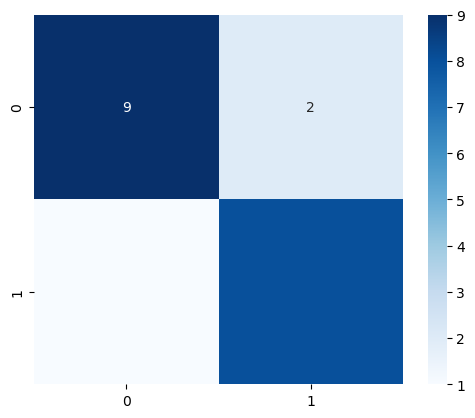

In [27]:
y_pred = unigram_model.predict(X_test)
matrix_confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d')

### Bigram matrix classifier

In [23]:

X_train, X_test, y_train, y_test = train_test_split(bigram_prob_matrix, df["CATEGORY"], test_size=0.2, random_state=42)

bigram_model = NaiveBayesClassifier()
bigram_model.fit(X_train, y_train)

accuracy = bigram_model.score(X_test, y_test)
print(f"\nAccuracy: {accuracy * 100:.2f}%")


Actual class distribution:
CATEGORY
education    11
sports        9
Name: count, dtype: int64

Predicted class distribution:
education    20
Name: count, dtype: int64

Accuracy: 55.00%


/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed 

<Axes: >

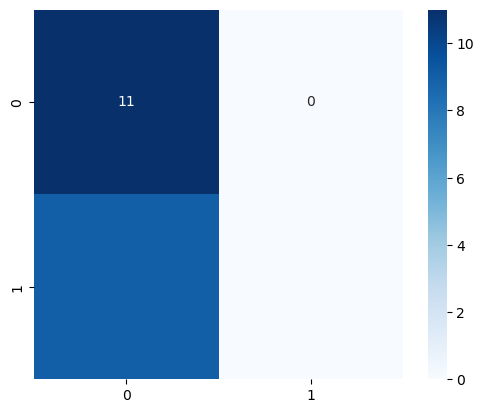

In [28]:
y_pred = bigram_model.predict(X_test)
matrix_confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d')

### TF IDF classifier

In [25]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df["CATEGORY"], test_size=0.2, random_state=42)

tfidf_model = NaiveBayesClassifier()
tfidf_model.fit(X_train, y_train)

accuracy = tfidf_model.score(X_test, y_test)
print(f"\nAccuracy: {accuracy * 100:.2f}%")


Actual class distribution:
CATEGORY
education    11
sports        9
Name: count, dtype: int64

Predicted class distribution:
education    17
sports        3
Name: count, dtype: int64

Accuracy: 70.00%


/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/husain3012/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed 

<Axes: >

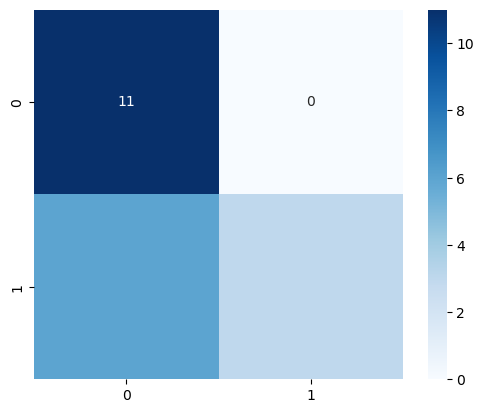

In [29]:
y_pred = tfidf_model.predict(X_test)
matrix_confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d')